### scikit-mobility tutorials

# 1 - Preprocessing

- [Preprocessing GPS data](#Preprocessing-GPS-data)
- [Preprocessing LBSN (social media) data](#Preprocessing-LBSN-&#40;social-media&#41;-data)

In [1]:
import skmob
# from skmob.core.trajectorydataframe import *
from skmob.utils import constants
from skmob.utils import utils

from geopy.distance import distance
import pandas as pd
import numpy as np

# Preprocessing GPS data

## Load data from file

Subsect of data from the Geolife project, available [here](https://www.microsoft.com/en-us/download/details.aspx?id=52367).

In [2]:
# %%time
tdf = skmob.TrajDataFrame.from_file('./data/geolife_sample.txt.gz', sep=',') 

In [3]:
tdf[:4]

lat         lng            datetime  uid
0  39.984094  116.319236 2008-10-23 05:53:05    1
1  39.984198  116.319322 2008-10-23 05:53:06    1
2  39.984224  116.319402 2008-10-23 05:53:11    1
3  39.984211  116.319389 2008-10-23 05:53:16    1

In [4]:
tdf.dtypes

lat                float64
lng                float64
datetime    datetime64[ns]
uid                  int64
dtype: object

In [5]:
tdf.crs

{'init': 'epsg:4326'}

In [6]:
tdf.parameters

{'from_file': './data/geolife_sample.txt.gz'}

##### Convert `datetime` column from original timezone `'GMT'` to local timezione `'Asia/Shanghai'`

In [7]:
tdf.rename(columns={'datetime' : 'original_datetime'}, inplace=True)
tdf['datetime'] = tdf['original_datetime'].\
                    dt.tz_localize('GMT').\
                    dt.tz_convert('Asia/Shanghai').\
                    dt.tz_localize(None)

tdf.drop(columns=['original_datetime'], inplace=True)
tdf[:4]

lat         lng  uid            datetime
0  39.984094  116.319236    1 2008-10-23 13:53:05
1  39.984198  116.319322    1 2008-10-23 13:53:06
2  39.984224  116.319402    1 2008-10-23 13:53:11
3  39.984211  116.319389    1 2008-10-23 13:53:16

#### Visualise the raw trajectories on a map

Plot the trajectories of `max_users=3` users. 

To save memory, each trajectory is downsampled so that at most `max_points=2000` points are plotted.

In [9]:
map_f = tdf.plot_trajectory(max_users=3, max_points=2000) #, tiles='Stamen Toner') # try this for a b/w map
map_f

# Save the plot to a html file
# map_f.save('./raw_trajectory.html')

Plot the first 10000 points of the trajectory of the user `'uid' == 1`

In [10]:
imin = 0
imax = 10000
map_f = tdf[tdf['uid'] == 1].plot_trajectory(imin=imin, imax=imax, weight=3, max_points=None) #, tiles='Stamen Toner')
map_f

## Filtering

Filter out all points with speed higher than `max_speed` km/h from the previous point.

In [11]:
from skmob.preprocessing import filtering

In [12]:
tdf.parameters

{'from_file': './data/geolife_sample.txt.gz'}

In [13]:
# %%time
ftdf = filtering.filter(tdf, max_speed=500.)

In [14]:
ftdf.parameters

{'from_file': './data/geolife_sample.txt.gz',
 'filter': {'function': 'filter',
  'max_speed': 500.0,
  'include_loops': False,
  'speed': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25}}

In [15]:
ftdf[:4]

lat         lng  uid            datetime
0  39.984094  116.319236    1 2008-10-23 13:53:05
1  39.984198  116.319322    1 2008-10-23 13:53:06
2  39.984224  116.319402    1 2008-10-23 13:53:11
3  39.984211  116.319389    1 2008-10-23 13:53:16

Very few points have been filtered.

In [16]:
print('Points of the raw trajectory: %s.'%len(tdf))
print('Points of the filtered trajectory: %s.'%len(ftdf))

Points of the raw trajectory: 217653.
Points of the filtered trajectory: 217599.


##### Inspect the filtered points

In [17]:
# %%time
merged = tdf.merge(ftdf, indicator=True, how='outer')
diff_df = merged[merged['_merge'] == 'left_only']

In [18]:
diff_df[:10]

lat         lng  uid            datetime     _merge
149    39.977648  116.326925    1 2008-10-23 18:33:00  left_only
17792  40.013398  116.306490    1 2008-10-27 20:27:55  left_only
23212  39.975403  116.312814    1 2008-10-31 14:15:21  left_only
23213  39.975342  116.312961    1 2008-10-31 14:15:23  left_only
24509  40.070867  116.301276    1 2008-11-01 09:06:36  left_only
24510  40.070832  116.301441    1 2008-11-01 09:06:37  left_only
25373  40.062216  116.294486    1 2008-11-01 12:17:41  left_only
25374  40.061976  116.294452    1 2008-11-01 12:17:42  left_only
25375  40.061711  116.294270    1 2008-11-01 12:17:43  left_only
25376  40.061615  116.294441    1 2008-11-01 12:17:44  left_only

Extract the filtered points between `2008-11-01 04:17:41` and `2008-11-01 04:17:44`.

In [19]:
imin = 25373 - 1
imax = 25376 + 1
dt_start = tdf.iloc[imin]['datetime']
dt_end = tdf.iloc[imax]['datetime']

filtered_tdf = ftdf[(ftdf['datetime'] >= dt_start) \
                 & (ftdf['datetime'] <= dt_end) \
                 & (ftdf['uid'] == 1)]

unfiltered_tdf = tdf[(tdf['datetime'] >= dt_start) \
                  & (tdf['datetime'] <= dt_end) \
                  & (tdf['uid'] == 1)]

In [20]:
filtered_tdf

lat         lng  uid            datetime
25366  40.064046  116.301866    1 2008-11-01 12:17:40
25367  40.061521  116.294584    1 2008-11-01 12:17:45

In [21]:
unfiltered_tdf

lat         lng  uid            datetime
25372  40.064046  116.301866    1 2008-11-01 12:17:40
25373  40.062216  116.294486    1 2008-11-01 12:17:41
25374  40.061976  116.294452    1 2008-11-01 12:17:42
25375  40.061711  116.294270    1 2008-11-01 12:17:43
25376  40.061615  116.294441    1 2008-11-01 12:17:44
25377  40.061521  116.294584    1 2008-11-01 12:17:45

Compute the speeds between consecutive points on the unfiltered trajectory

In [25]:
la_lo_dt = unfiltered_tdf[['lat', 'lng', 'datetime']].values

In [26]:
# average speed (km/h) between the last point not filtered and the following points

i0 = 0 
la0, lo0, dt0 = la_lo_dt[i0]
pd.DataFrame(
    [[dt0, dt , distance((la,lo), (la0, lo0)).km / ((dt - dt0).seconds / 3600) ] \
     for i,(la,lo,dt) in enumerate(la_lo_dt[i0+1:])], \
             columns=['time 0', 'time 1', 'speed (km/h)'])

time 0              time 1  speed (km/h)
0 2008-11-01 12:17:40 2008-11-01 12:17:41   2381.767297
1 2008-11-01 12:17:40 2008-11-01 12:17:42   1211.387556
2 2008-11-01 12:17:40 2008-11-01 12:17:43    837.594263
3 2008-11-01 12:17:40 2008-11-01 12:17:44    619.722216
4 2008-11-01 12:17:40 2008-11-01 12:17:45    490.752215

All points with speed higher than `max_speed=500.` km/h have been filtered.

In [27]:
# average speed (km/h) between consecutive filtered points

pd.DataFrame(
[[dt, la_lo_dt[i+1][2], distance((la,lo), la_lo_dt[i+1][:-1]).km / \
 ((la_lo_dt[i+1][2] - dt).seconds / 3600) ] \
     for i,(la,lo,dt) in enumerate(la_lo_dt[:-1])], \
columns=['time 0', 'time 1', 'speed (km/h)'])

time 0              time 1  speed (km/h)
0 2008-11-01 12:17:40 2008-11-01 12:17:41   2381.767297
1 2008-11-01 12:17:41 2008-11-01 12:17:42     96.501638
2 2008-11-01 12:17:42 2008-11-01 12:17:43    119.772858
3 2008-11-01 12:17:43 2008-11-01 12:17:44     65.046388
4 2008-11-01 12:17:44 2008-11-01 12:17:45     57.800699

##### Visualise the filtered points

In [28]:
# Cut a buffer of 10 points arounfd the filtered part
user_id = 1

imin = 25373 - 10
imax = 25376 + 10
dt_start = tdf.iloc[imin]['datetime']
dt_end = tdf.iloc[imax]['datetime']

filtered_tdf = ftdf[(ftdf['datetime'] >= dt_start) \
                 & (ftdf['datetime'] <= dt_end) \
                 & (ftdf['uid'] == user_id)]

unfiltered_tdf = tdf[(tdf['datetime'] >= dt_start) \
                  & (tdf['datetime'] <= dt_end) \
                  & (tdf['uid'] == user_id)]

In [29]:
map_f = unfiltered_tdf.plot_trajectory(zoom=15, weight=10, opacity=0.5) #, tiles='Stamen Toner')
map_f = filtered_tdf.plot_trajectory(map_f=map_f, max_users=1)

map_f

- The thick line is the unfiltered trajectory (`unfiltered_tdf`)
- The thin line is the filtered trajectory (`filtered_tdf`)

## Compression

Reduce the number of points of the trajectory, preserving the structure.

In [29]:
from skmob.preprocessing import compression

Merge together all points that are closer than `spatial_radius=0.2` kilometers from each other.

In [30]:
# %%time

ctdf = compression.compress(ftdf, spatial_radius=0.2)
ctdf[:4]

lat         lng            datetime  uid
0  39.984302  116.320730 2008-10-23 05:53:05    1
1  39.982115  116.321225 2008-10-23 05:56:06    1
2  39.979737  116.321564 2008-10-23 05:57:03    1
3  39.979672  116.323778 2008-10-23 05:59:05    1

In [31]:
ctdf.parameters

{'file': '../data_test/geolife_sample.txt.gz',
 'filter': {'function': 'filter',
  'max_speed': 500.0,
  'include_loops': False,
  'speed': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius': 0.2}}

The compressed trajectory has only a small fraction of the points of the filtered trajectory.

In [33]:
print('Points of the filtered trajectory: %s.'%len(ftdf))
print('Points of the compressed trajectory: %s.'%len(ctdf))

Points of the filtered trajectory: 217599.
Points of the compressed trajectory: 6278.


##### Visualise the filtered and compressed trajectories

Show the first 10000 points of the filtered trajectory.

In [34]:
user_id = 1

imin = 0
imax = 10000
dt_start = tdf.iloc[imin]['datetime']
dt_end = tdf.iloc[imax]['datetime']

filtered_tdf = ftdf[(ftdf['datetime'] >= dt_start) \
                 & (ftdf['datetime'] <= dt_end) \
                 & (ftdf['uid'] == user_id)]

compressed_tdf = ctdf[(ctdf['datetime'] >= dt_start) \
                  & (ctdf['datetime'] <= dt_end) \
                  & (ctdf['uid'] == user_id)]

filtered_tdf[:3]

lat         lng  uid            datetime
0  39.984094  116.319236    1 2008-10-23 13:53:05
1  39.984198  116.319322    1 2008-10-23 13:53:06
2  39.984224  116.319402    1 2008-10-23 13:53:11

In [35]:
map_f = plot.plot_trajectory(filtered_tdf, weight=5, opacity=0.5, max_points=None)
map_f = plot.plot_trajectory(compressed_tdf, map_f=map_f, max_points=None)

map_f

- The thick line is the filtered trajectory (`filtered_tdf`)
- The thin line is the compressed trajectory (`compressed_tdf`)

## Stop detection

Identify locations where the user was stationary, i.e. 
if the user spend at least `minutes_for_a_stop` minutes within a distance `stop_radius` from a given point. 

The new column `leaving_datetime` is added to the TrajectoryDataFrame, indicating the time when the user departs from the stop.

In [32]:
from skmob.preprocessing import detection

In [33]:
# %%time

stdf = detection.stops(ctdf, stop_radius_factor=0.5, \
            minutes_for_a_stop=20.0, spatial_radius=0.2, leaving_time=True)
stdf[:4]

lat         lng            datetime  uid    leaving_datetime
0  39.978253  116.327275 2008-10-23 06:01:05    1 2008-10-23 10:32:53
1  40.013819  116.306532 2008-10-23 11:10:09    1 2008-10-23 23:46:02
2  39.978987  116.326686 2008-10-24 00:10:39    1 2008-10-24 01:48:57
3  39.981316  116.310181 2008-10-24 01:56:47    1 2008-10-24 03:21:09

In [34]:
stdf.parameters

{'file': '../data_test/geolife_sample.txt.gz',
 'filter': {'function': 'filter',
  'max_speed': 500.0,
  'include_loops': False,
  'speed': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius': 0.2},
 'detect': {'function': 'stops',
  'stop_radius_factor': 0.5,
  'minutes_for_a_stop': 20.0,
  'spatial_radius': 0.2,
  'leaving_time': True}}

In [11]:
stdf.dtypes

lat                        float64
lng                        float64
uid                          int64
datetime            datetime64[ns]
leaving_datetime    datetime64[ns]
dtype: object

##### Visualise the compressed trajectory and the stops

Click on the stop markers to see a pop up with: 
- User ID
- Coordinates of the stop (click to see the location on Google maps)
- Arrival time
- Departure time

In [39]:

map_f = ctdf.plot_trajectory(max_points=1000, hex_color=-1)
map_f = stdf.plot_stops(map_f=map_f, hex_color=-1)

map_f

## Clustering stops

Stops are clustered by spatial proximity using DBSCAN.

The new column `cluster` is added to the Stops TrajectoryDataFrame, where the value correspond to the cluster ID each stop belong to. 

Clusters IDs are integers (0, 1, ...): 0 is the most visited cluster, 1 is the second most visited, ...

In [35]:
from skmob.preprocessing import clustering

In [36]:
# %%time

cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)

In [15]:
cstdf[:4]

lat         lng  uid            datetime    leaving_datetime  cluster
0  39.978253  116.327275    1 2008-10-23 14:01:05 2008-10-23 18:32:53        0
1  40.013819  116.306532    1 2008-10-23 19:10:09 2008-10-24 07:46:02        1
2  39.978987  116.326686    1 2008-10-24 08:10:39 2008-10-24 09:48:57        0
3  39.981316  116.310181    1 2008-10-24 09:56:47 2008-10-24 11:21:09        7

In [37]:
cstdf.parameters

{'file': '../data_test/geolife_sample.txt.gz',
 'filter': {'function': 'filter',
  'max_speed': 500.0,
  'include_loops': False,
  'speed': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius': 0.2},
 'detect': {'function': 'cluster', 'cluster_radius_km': 0.1, 'min_samples': 1}}

##### Visualise the compressed trajectory and stops: stops in the same clusters have the same color.

Click on the stop markers to see a pop up with: 
- User ID
- Cluster ID
- Coordinates of the stop (click to see the location on Google maps)
- Arrival time
- Departure time

In [48]:
map_f = ctdf[ctdf['uid'] == 1].plot_trajectory(max_points=None, hex_color='#000000')

cstdf[stdf['uid'] == 1].plot_stops(map_f=map_f)

In [49]:
map_f = ctdf.plot_trajectory(max_points=1000, hex_color=-1)
cstdf.plot_stops(map_f=map_f)

#### Visualise a user's diary

/Users/fs13378/miniconda3/envs/skmob_dev/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


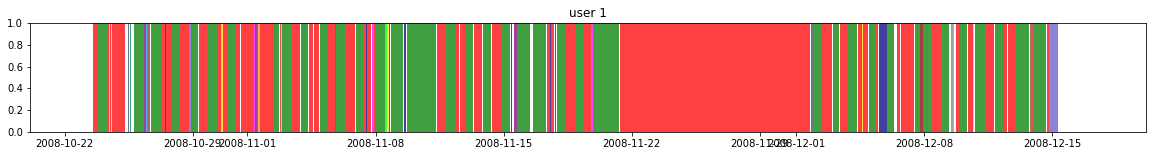

In [50]:
user = 1

start_datetime = pd.to_datetime('2008-10-20 030000')
end_datetime = pd.to_datetime('2008-12-20 030000')

ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

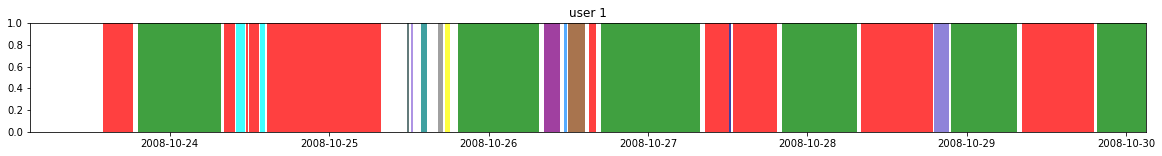

In [51]:
user = 1

start_datetime = pd.to_datetime('2008-10-23 030000')
end_datetime = pd.to_datetime('2008-10-30 030000')

ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

## Split trajectory into daily trajectories

In [52]:
groups = utils.group_df_by_time(cstdf[cstdf['uid'] == 1], 
                        offset_value=3, offset_unit='hours', add_starting_location=True)
groups[:3]

[         lat         lng  uid            datetime    leaving_datetime  cluster
 0  39.978253  116.327275    1 2008-10-23 14:01:05 2008-10-23 18:32:53        0
 1  40.013819  116.306532    1 2008-10-23 19:10:09 2008-10-24 07:46:02        1,
          lat         lng  uid            datetime    leaving_datetime  cluster
 0  40.013819  116.306532    1 2008-10-23 19:10:09 2008-10-24 07:46:02        1
 1  39.978987  116.326686    1 2008-10-24 08:10:39 2008-10-24 09:48:57        0
 2  39.981316  116.310181    1 2008-10-24 09:56:47 2008-10-24 11:21:09        7
 3  39.979580  116.313649    1 2008-10-24 11:26:35 2008-10-24 11:50:36       42
 4  39.978696  116.326220    1 2008-10-24 11:55:33 2008-10-24 13:30:40        0
 5  39.981538  116.310790    1 2008-10-24 13:36:46 2008-10-24 14:23:07        7
 6  39.978161  116.327242    1 2008-10-24 14:34:30 2008-10-25 07:44:05        0,
          lat         lng  uid            datetime    leaving_datetime  cluster
 0  39.978161  116.327242    1 2008-10

#### Visualise the diaries of each sub-trajectory

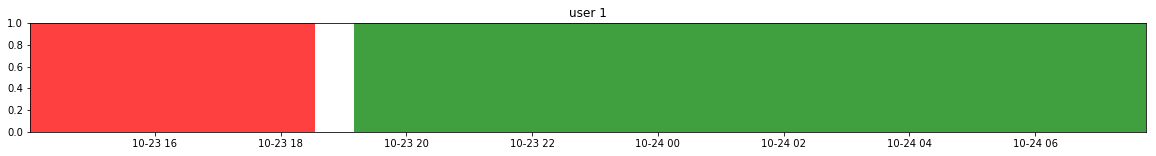

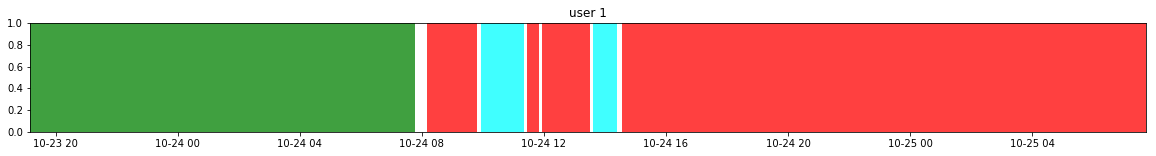

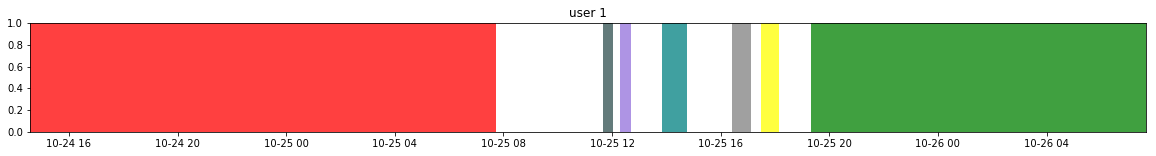

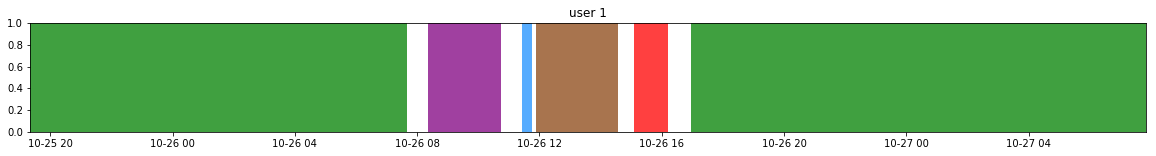

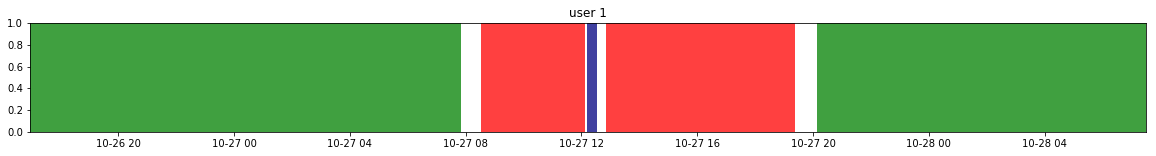

In [53]:
for tdf in groups[:5]:
    user = tdf['uid'].iloc[0]
    ax = tdf.plot_diary(user)

# Preprocessing LBSN (social media) data

## Load data 
Checkin data from Brightkite, available [here](https://snap.stanford.edu/data/loc-Brightkite.html).

In [3]:
# only load the first 10000 rows

url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\t', header=0, nrows=10000, 
                 names=['user', 'check-in_time', "latitude", "longitude", "location id"]
                )
print(len(df))
df[:4]

10000


user         check-in_time   latitude   longitude  \
0     0  2010-10-16T06:02:04Z  39.891383 -105.070814   
1     0  2010-10-16T03:48:54Z  39.891077 -105.068532   
2     0  2010-10-14T18:25:51Z  39.750469 -104.999073   
3     0  2010-10-14T00:21:47Z  39.752713 -104.996337   

                                location id  
0          7a0f88982aa015062b95e3b4843f9ca2  
1          dd7cd3d264c2d063832db506fba8bf79  
2  9848afcc62e500a01cf6fbf24b797732f8963683  
3          2ef143e12038c870038df53e0478cefc

In [4]:
df.dtypes

user               int64
check-in_time     object
latitude         float64
longitude        float64
location id       object
dtype: object

Create the `TrajectoryDataFrame`

In [5]:
tdf = TrajDataFrame(df, latitude='latitude', longitude='longitude', datetime='check-in_time',user_id='user')
tdf[:4]

uid                  datetime        lat         lng  \
0    0 2010-10-16 06:02:04+00:00  39.891383 -105.070814   
1    0 2010-10-16 03:48:54+00:00  39.891077 -105.068532   
2    0 2010-10-14 18:25:51+00:00  39.750469 -104.999073   
3    0 2010-10-14 00:21:47+00:00  39.752713 -104.996337   

                                location id  
0          7a0f88982aa015062b95e3b4843f9ca2  
1          dd7cd3d264c2d063832db506fba8bf79  
2  9848afcc62e500a01cf6fbf24b797732f8963683  
3          2ef143e12038c870038df53e0478cefc

Drop the column `location id`

In [6]:
tdf.drop(columns=['location id'], inplace=True)
tdf[:4]

uid                  datetime        lat         lng
0    0 2010-10-16 06:02:04+00:00  39.891383 -105.070814
1    0 2010-10-16 03:48:54+00:00  39.891077 -105.068532
2    0 2010-10-14 18:25:51+00:00  39.750469 -104.999073
3    0 2010-10-14 00:21:47+00:00  39.752713 -104.996337

Sort rows by user ID and time

In [7]:
tdf.dtypes

uid                       int64
datetime    datetime64[ns, UTC]
lat                     float64
lng                     float64
dtype: object

Delocalize the `datetime` column (remove timezone info)

In [33]:
tdf['datetime'] = tdf['datetime'].dt.tz_localize(None)
tdf[:4]

uid            datetime        lat         lng
2098    0 2009-05-25 20:56:10  37.774929 -122.419415
2097    0 2009-05-25 21:35:28  37.600747 -122.382376
2096    0 2009-05-25 21:37:44  37.600747 -122.382376
2095    0 2009-05-25 21:42:47  37.600747 -122.382376

In [34]:
tdf.dtypes

uid                  int64
datetime    datetime64[ns]
lat                float64
lng                float64
dtype: object

## Filtering

Filter out all points with speed higher than `max_speed` km/h from the previous point.

In [8]:
from skmob.preprocessing import filtering

In [35]:
ftdf = filtering.filter(tdf, max_speed=500.)
ftdf[:4]

uid            datetime        lat         lng
0    0 2009-05-25 20:56:10  37.774929 -122.419415
1    0 2009-05-25 21:35:28  37.600747 -122.382376
2    0 2009-05-25 21:37:44  37.600747 -122.382376
3    0 2009-05-25 21:42:47  37.600747 -122.382376

In [36]:
print('Points of the raw trajectory: %s.'%len(tdf))
print('Points of the filtered trajectory: %s.'%len(ftdf))

Points of the raw trajectory: 10000.
Points of the filtered trajectory: 9727.


## Compression

Reduce the number of points of the trajectory, preserving the structure.

In [37]:
from skmob.preprocessing import compression

Merge together all points that are closer than `spatial_radius=0.2` kilometers from each other.

In [38]:
# %%time

ctdf = compression.compress(ftdf, spatial_radius=0.2)
ctdf[:4]

uid            datetime        lat         lng
0    0 2009-05-25 20:56:10  37.774929 -122.419415
1    0 2009-05-25 21:35:28  37.600747 -122.382376
2    0 2009-05-25 22:13:23  37.615223 -122.389979
3    0 2009-05-26 02:21:12  39.878664 -104.682105

The compressed trajectory has only a small fraction of the points of the filtered trajectory.

In [39]:
print('Points of the filtered trajectory: %s.'%len(ftdf))
print('Points of the compressed trajectory: %s.'%len(ctdf))

Points of the filtered trajectory: 9727.
Points of the compressed trajectory: 6341.


##### Visualise the filtered and compressed trajectories

Show the first 10000 points of the filtered trajectory.

In [40]:
user = 1

imin = 0
imax = 100
dt_start = ftdf[ftdf['uid'] == user]['datetime'].min()
dt_end = ftdf[ftdf['uid'] == user]['datetime'].max()

filtered_tdf = ftdf[(ftdf['datetime'] >= dt_start) \
                 & (ftdf['datetime'] <= dt_end) \
                 & (ftdf['uid'] == user)]

compressed_tdf = ctdf[(ctdf['datetime'] >= dt_start) \
                  & (ctdf['datetime'] <= dt_end) \
                  & (ctdf['uid'] == user)]

filtered_tdf[:3]

uid            datetime        lat         lng
0    1 2009-03-30 05:21:35  37.630490 -122.411084
1    1 2009-03-30 17:25:55  37.584103 -122.366083
2    1 2009-03-31 02:58:28  37.385773 -121.898845

In [41]:

map_f = filtered_tdf.plot_trajectory(weight=5, opacity=0.5, max_points=None)
compressed_tdf.plot_trajectory(map_f=map_f, max_points=None)


## Stop detection

Identify locations where the user was stationary, i.e. 
if the user spend at least `minutes_for_a_stop` minutes within a distance `stop_radius` from a given point. 

The new column `leaving_datetime` is added to the TrajectoryDataFrame, indicating the time when the user departs from the stop.

In [42]:
from skmob.preprocessing import detection

In [43]:
# %%time

stdf = detection.stops(ctdf, stop_radius_factor=0.95, \
            minutes_for_a_stop=20.0, spatial_radius=0.2, leaving_time=True)
stdf[:4]

uid            datetime        lat         lng    leaving_datetime
0    0 2009-05-25 20:56:10  37.774929 -122.419415 2009-05-25 21:35:28
1    0 2009-05-25 21:35:28  37.600747 -122.382376 2009-05-25 22:13:23
2    0 2009-05-25 22:13:23  37.615223 -122.389979 2009-05-26 02:21:12
3    0 2009-05-26 02:21:12  39.878664 -104.682105 2009-05-26 04:59:44

##### Visualise the compressed trajectory and the stops

Click on the stop markers to see a pop up with: 
- User ID
- Coordinates of the stop (click to see the location on Google maps)
- Arrival time
- Departure time

In [44]:
user = 1

map_f = ctdf[ctdf['uid'] == user].plot_trajectory(max_users=1, max_points=1000, hex_color=-1 )
stdf[stdf['uid'] == user].plot_stops(max_users=1, map_f=map_f, hex_color=-1, popup=False)


## Clustering stops

Stops are clustered by spatial proximity using DBSCAN.

The new column `cluster` is added to the Stops TrajectoryDataFrame, where the value correspond to the cluster ID each stop belong to. 

Clusters IDs are integers (0, 1, ...): 0 is the most visited cluster, 1 is the second most visited, ...

In [45]:
from skmob.preprocessing import clustering

In [46]:
# %%time

cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)
cstdf[:4]

uid            datetime        lat         lng    leaving_datetime  cluster
0    0 2009-05-25 20:56:10  37.774929 -122.419415 2009-05-25 21:35:28      238
1    0 2009-05-25 21:35:28  37.600747 -122.382376 2009-05-25 22:13:23       97
2    0 2009-05-25 22:13:23  37.615223 -122.389979 2009-05-26 02:21:12       70
3    0 2009-05-26 02:21:12  39.878664 -104.682105 2009-05-26 04:59:44       51

#### Write `TrajDataFrame` to file

- including the `tdf.parameters`
- automatically preserve the dtype of columns with time stamps (time zone info is lost though).

**Caveat**: dtypes other than `int`, `float` and `datetime` may not be identical to the original dtype after loading from a json file. 

Check with `tdf.dtypes` and manually convert each column to the proper dtype, if needed. 

In [47]:
skmob.write(cstdf, './brightkite_clustered_stops.json')

In [48]:
cstdf.dtypes

uid                          int64
datetime            datetime64[ns]
lat                        float64
lng                        float64
leaving_datetime    datetime64[ns]
cluster                      int64
dtype: object

In [49]:
cstdf.parameters

{'filter': {'function': 'filter',
  'max_speed': 500.0,
  'include_loops': False,
  'speed': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius': 0.2},
 'detect': {'function': 'cluster', 'cluster_radius_km': 0.1, 'min_samples': 1}}

#### Load `TrajDataFrame` from file

In [50]:
cstdf2 = skmob.read('./brightkite_clustered_stops.json')
cstdf2[:4]

uid            datetime        lat         lng    leaving_datetime  cluster
0    0 2009-05-25 20:56:10  37.774929 -122.419415 2009-05-25 21:35:28      238
1    0 2009-05-25 21:35:28  37.600747 -122.382376 2009-05-25 22:13:23       97
2    0 2009-05-25 22:13:23  37.615223 -122.389979 2009-05-26 02:21:12       70
3    0 2009-05-26 02:21:12  39.878664 -104.682105 2009-05-26 04:59:44       51

In [51]:
cstdf2.dtypes

uid                          int64
datetime            datetime64[ns]
lat                        float64
lng                        float64
leaving_datetime    datetime64[ns]
cluster                      int64
dtype: object

In [52]:
cstdf2.parameters

{'filter': {'function': 'filter',
  'max_speed': 500.0,
  'include_loops': False,
  'speed': 5.0,
  'max_loop': 6,
  'ratio_max': 0.25},
 'compress': {'function': 'compress', 'spatial_radius': 0.2},
 'detect': {'function': 'cluster', 'cluster_radius_km': 0.1, 'min_samples': 1}}

##### Visualise the compressed trajectory and stops: stops in the same clusters have the same color.

Click on the stop markers to see a pop up with: 
- User ID
- Cluster ID
- Coordinates of the stop (click to see the location on Google maps)
- Arrival time
- Departure time

In [29]:
user = 1

# map_f = ctdf[ctdf['uid'] == 1].plot_trajectory(max_points=200, hex_color='#000000')
cstdf[stdf['uid'] == user].plot_stops(popup=True )#, map_f=map_f)


#### Visualise a user's diary

/Users/fs13378/miniconda3/envs/skmob_dev/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


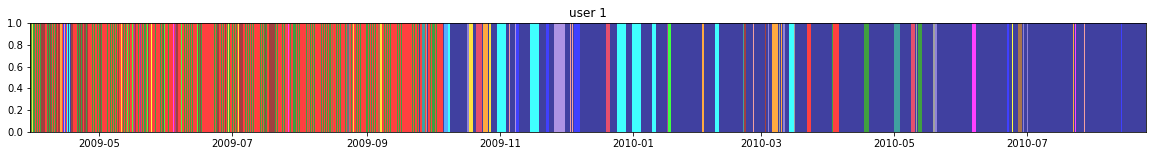

In [30]:
user = 1

ax = cstdf.plot_diary(user)

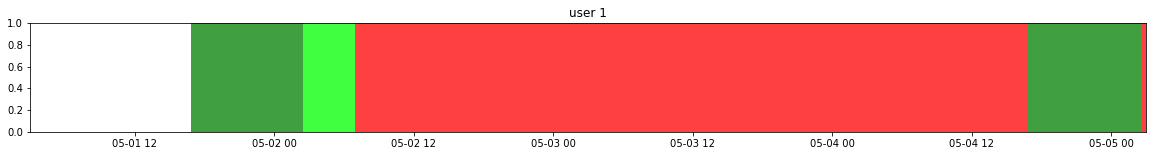

In [54]:
user = 1

start_datetime = pd.to_datetime('2009-05-1 030000')
end_datetime = pd.to_datetime('2009-05-5 030000')

ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

Plot diary onto map

In [55]:
# start_datetime = pd.to_datetime('2009-05-1 030000')
# end_datetime = pd.to_datetime('2009-05-21 030000')

selection = (ctdf['uid'] == user) & (start_datetime <= ctdf['datetime']) & ( ctdf['datetime']  <= end_datetime)
map_f = ctdf[selection].plot_trajectory(max_points=1000, hex_color='#000000')

selection = (stdf['uid'] == user) & (start_datetime <= stdf['datetime']) & ( stdf['datetime']  <= end_datetime)
map_f = cstdf[selection].plot_stops(popup=True , map_f=map_f)

map_f

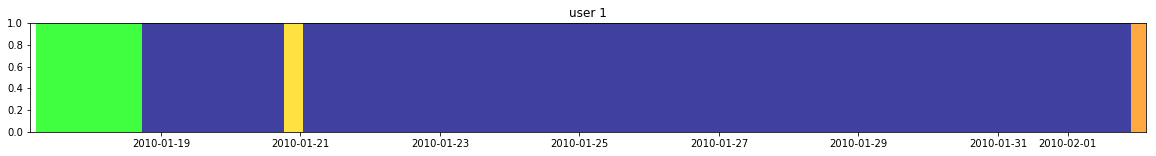

In [56]:
user = 1

start_datetime = pd.to_datetime('2010-01-17 030000')
end_datetime = pd.to_datetime('2010-02-2 030000')

ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

Plot diary onto map

In [57]:
# start_datetime = pd.to_datetime('2009-05-1 030000')
# end_datetime = pd.to_datetime('2009-05-21 030000')

selection = (ctdf['uid'] == user) & (start_datetime <= ctdf['datetime']) & ( ctdf['datetime']  <= end_datetime)
map_f = ctdf[selection].plot_trajectory(max_points=1000, hex_color='#000000')

selection = (stdf['uid'] == user) & (start_datetime <= stdf['datetime']) & ( stdf['datetime']  <= end_datetime)
map_f = cstdf[selection].plot_stops(popup=True , map_f=map_f)

map_f